In [1]:
# Import Packages
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import corner
import pymc as pm
import arviz as az
import scipy
import scipy.stats as stats
import xarray as xr
from scipy.stats import invgamma, norm, gamma, multivariate_normal, linregress
from statsmodels.graphics.tsaplots import plot_acf
from numpy.lib.histograms import histogram
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

print('Python version:', sys.version)
print('pymc version', pm.__version__)
print('arviz version', az.__version__)
print('numpy version', np.__version__)
print('pandas version', pd.__version__)
print('seaborn version', sns.__version__)
print('Pyplot (Matplotlib) version:', plt.matplotlib.__version__)
print('Scipy Stats', scipy.__version__)
print('xarray', xr.__version__)

Python version: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
pymc version 5.16.1
arviz version 0.17.1
numpy version 1.26.4
pandas version 2.2.2
seaborn version 0.11.0
Pyplot (Matplotlib) version: 3.8.4
Scipy Stats 1.12.0
xarray 2023.6.0


In [2]:
file_path = 'data/bv_rhk_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data
data


,Cluster_Name,Cluster,(B-V),Log(R_HK),Age_Myr
0,US,1,0.86,-4.28,10
1,US,1,0.68,-4.04,10
2,US,1,0.62,-4.01,10
3,US,1,0.82,-4.17,10
4,US,1,0.74,-4.07,10
...,...,...,...,...,...
198,M67,9,0.58,-4.78,4000
199,M67,9,0.62,-4.88,4000
200,M67,9,0.72,-4.86,4000
201,M67,9,0.64,-4.82,4000


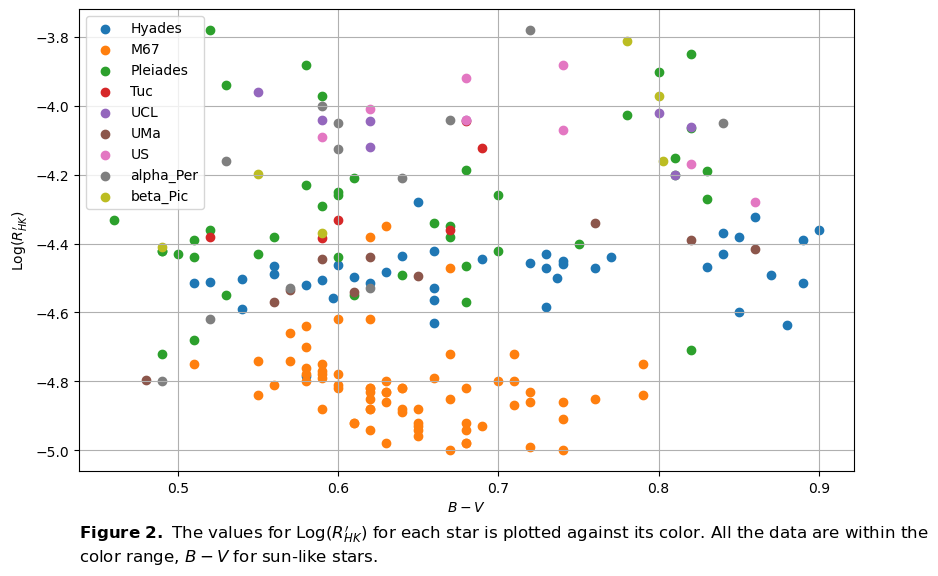

In [3]:
# Plot the data
plt.figure(figsize=(10, 6))
# Plot each group separately for clarity
for Cluster_Name, group_data in data.groupby("Cluster_Name"):
    plt.scatter(group_data["(B-V)"], group_data["Log(R_HK)"], label=f"{Cluster_Name}")
# Add labels, title, and legend
plt.xlabel("$\mathit{B-V}$")
plt.ylabel("Log($R^\prime_{HK}$)")
plt.figtext(
    0.125, -0.035, 
    r"$\mathbf{Figure\ 2.}$ The values for Log($R^\prime_{HK}$) for each star "
    "is plotted against its color. All the data are within the color range, "
    r"$\mathit{B-V}$ for sun-like stars.", 
    wrap=True, horizontalalignment='left', fontsize=12
)

plt.legend()
plt.grid(True)

plt.savefig("Figure 2", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
# Calculate Stats
group_stats = data.groupby('Cluster_Name')['Log(R_HK)'].agg(['mean', 'std'])
cluster_age = data.groupby('Cluster_Name')['Age_Myr'].agg('mean')

# Combine the results
summary = pd.merge(group_stats, cluster_age, on='Cluster_Name', how='inner')

# Reset the index to include 'Cluster_Name' as a column
summary.reset_index(inplace=True)

# Save to CSV
summary.to_csv('data/summary.csv', index=False)  # index=False ensures no extra index column in the CSV

# Display the summary DataFrame
summary


,Cluster_Name,mean,std,Age_Myr
0,Hyades,-4.485976,0.090107,700.0
1,M67,-4.817857,0.125731,4000.0
2,Pleiades,-4.299286,0.229633,130.0
3,Tuc,-4.270556,0.147756,45.0
4,UCL,-4.060625,0.071536,16.0
5,UMa,-4.496500,0.127455,500.0
6,US,-4.057500,0.128924,10.0
7,alpha_Per,-4.241250,0.305719,85.0
8,beta_Pic,-4.152611,0.230746,24.0


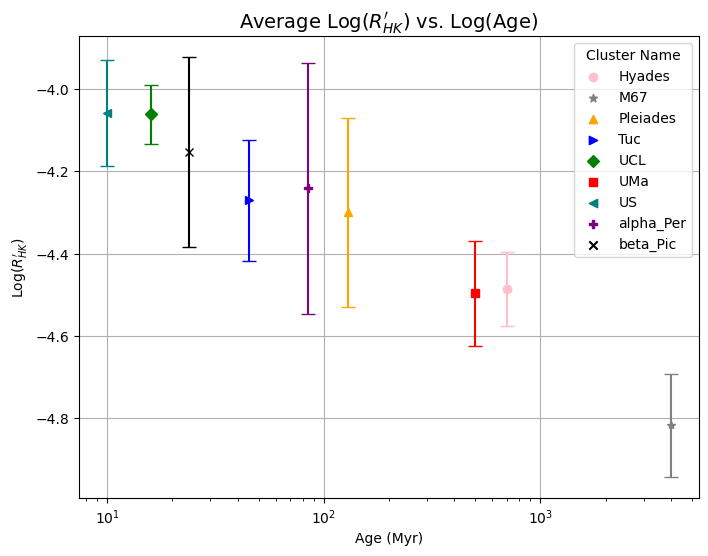

In [6]:
# Data from the summary DataFrame
ages = summary['Age_Myr']  # Age in Myr
log_RHK = summary['mean']  # Log(R'HK) values
y_errors = summary['std']  # Y error bars
cluster_names = summary['Cluster_Name']  # Cluster names

# Markers and colors for each point
markers = ['o', '*', '^', '>', 'D', 's', '<', 'P', 'x']
colors = ['pink', 'gray', 'orange', 'blue', 'green', 'red', 'teal', 'purple', 'black']

# Create the plot
plt.figure(figsize=(8, 6))

for i in range(len(ages)):
    # Plot data with error bars
    plt.errorbar(
        ages.iloc[i], log_RHK.iloc[i],
        yerr=y_errors.iloc[i],
        fmt=markers[i], color=colors[i], capsize=5
    )
    # Add invisible scatter points to define the legend
    plt.scatter([], [], marker=markers[i], color=colors[i], label=cluster_names.iloc[i])

# Customize plot
plt.xscale('log')  # Logarithmic scale for X-axis
plt.xlabel('Age (Myr)')
plt.ylabel('Log($R^\prime_{HK}$)')
plt.title('Average Log($R^\prime_{HK}$) vs. Log(Age)', fontsize=14)

# Add the legend
plt.legend(title='Cluster Name', loc='best', fontsize=10)

# Add grid for better readability
plt.grid(True)

# Save and display
plt.savefig("Figure 3.png", dpi=300, bbox_inches="tight")
plt.show()


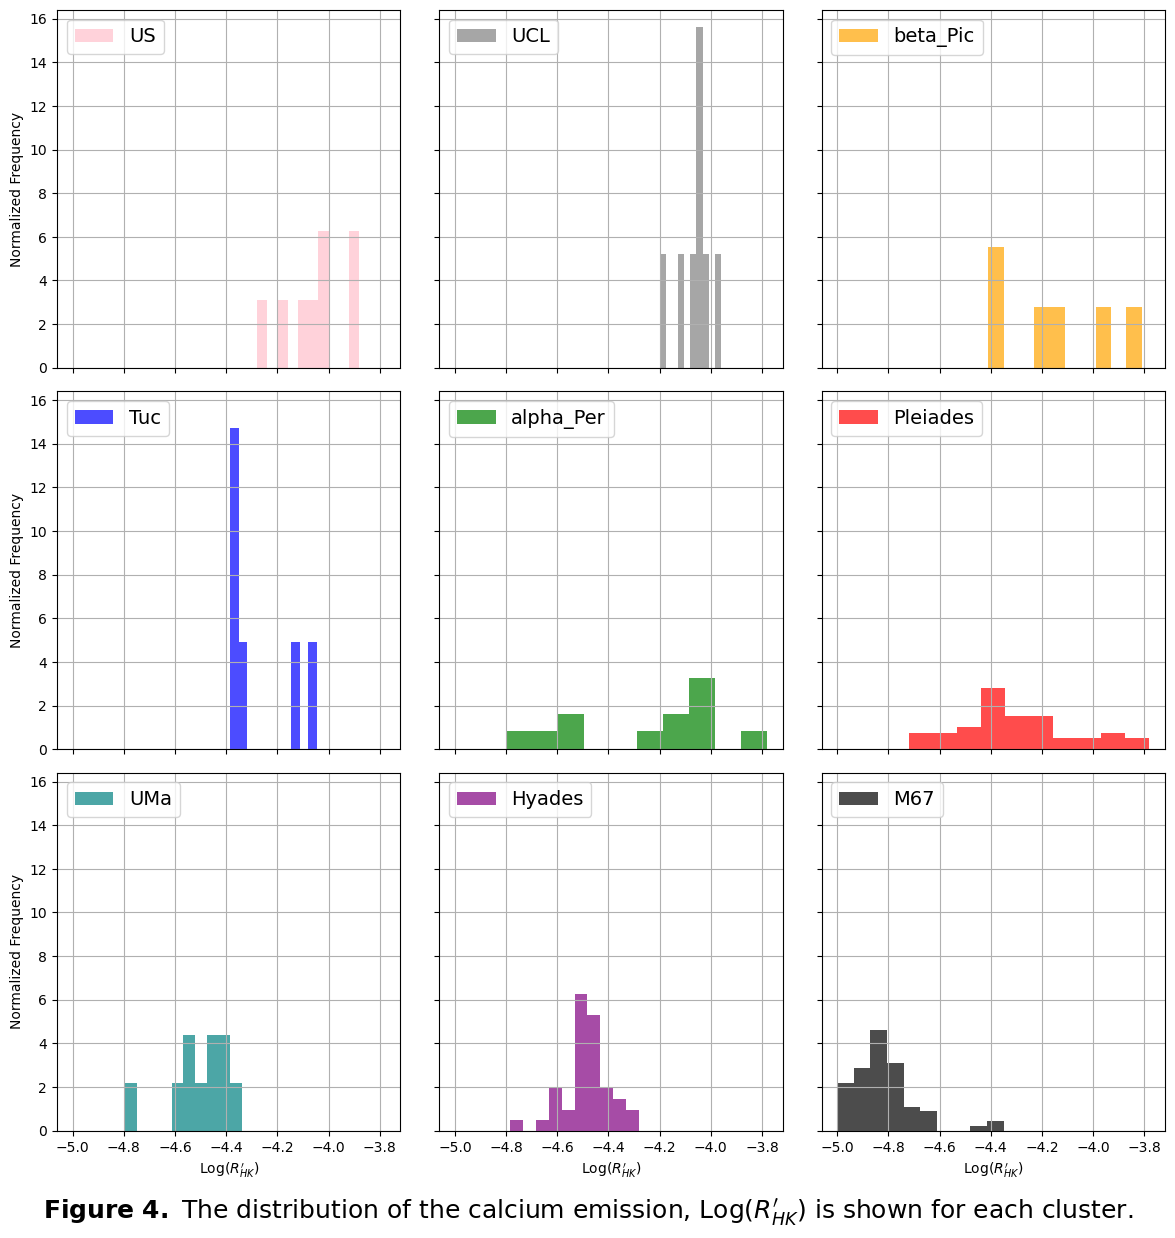

In [8]:
# Assuming your CSV has columns 'Cluster_Name' and 'Log(R_HK)'
clusters = data['Cluster_Name'].unique()  # Get unique cluster names
colors = ['pink', 'gray', 'orange', 'blue', 'green', 'red', 'teal', 'purple', 'black']  # Ensure enough colors for clusters

# Set up the 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each cluster and plot its histogram
for i, cluster in enumerate(clusters):
    # Filter data for the current cluster
    cluster_data = data[data['Cluster_Name'] == cluster]['Log(R_HK)']
    
    # Plot histogram
    axes[i].hist(
        cluster_data, bins=10, color=colors[i], density=True, alpha=0.7, label=cluster
    )
    axes[i].legend(fontsize=14, loc='upper left')
    axes[i].grid(True)

# Set x-axis label for the last row of plots
for ax in axes[6:]:
    ax.set_xlabel('Log($R^\prime_{HK}$)')

# Set y-axis label for the first column of plots
for ax in axes[::3]:
    ax.set_ylabel('Normalized Frequency')

# Hide unused subplots (if fewer than 9 clusters)
for i in range(len(clusters), 9):
    axes[i].axis('off')

plt.figtext(
    0.04, -0.02, 
    r"$\mathbf{Figure\ 4.}$ The distribution of the calcium emission, Log($R^\prime_{HK}$) is shown for each cluster.", 
    wrap=True, horizontalalignment='left', fontsize=18
)

plt.tight_layout()
plt.savefig("Figure 4", dpi=300, bbox_inches="tight")
plt.show()
